In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
import collections

In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

def get_doc_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir
def save_doc_img(img, name):
    mpimg.imsave(os.path.join(get_doc_dir(), name + '.jpg'), img)

def use_debug():
    return True

In [9]:
def undistort(img,mtx,dist,verbose= False):
    ##calculate the distortion coffecient and calibration matrix use cv2.calibrateCamera
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ##undistort input images
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
    return undist


In [4]:
def cam_calibration(image_dir,nx,ny,verbose=False):
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Step through the list and search for chessboard corners
    
    
    # make a list of calibration images
    images= glob.glob(os.path.join(image_dir,"calibration*.jpg"))
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        if verbose:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img',img)
            plt.imshow(img)#cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret,mtx,dist,rvecs,tvecs

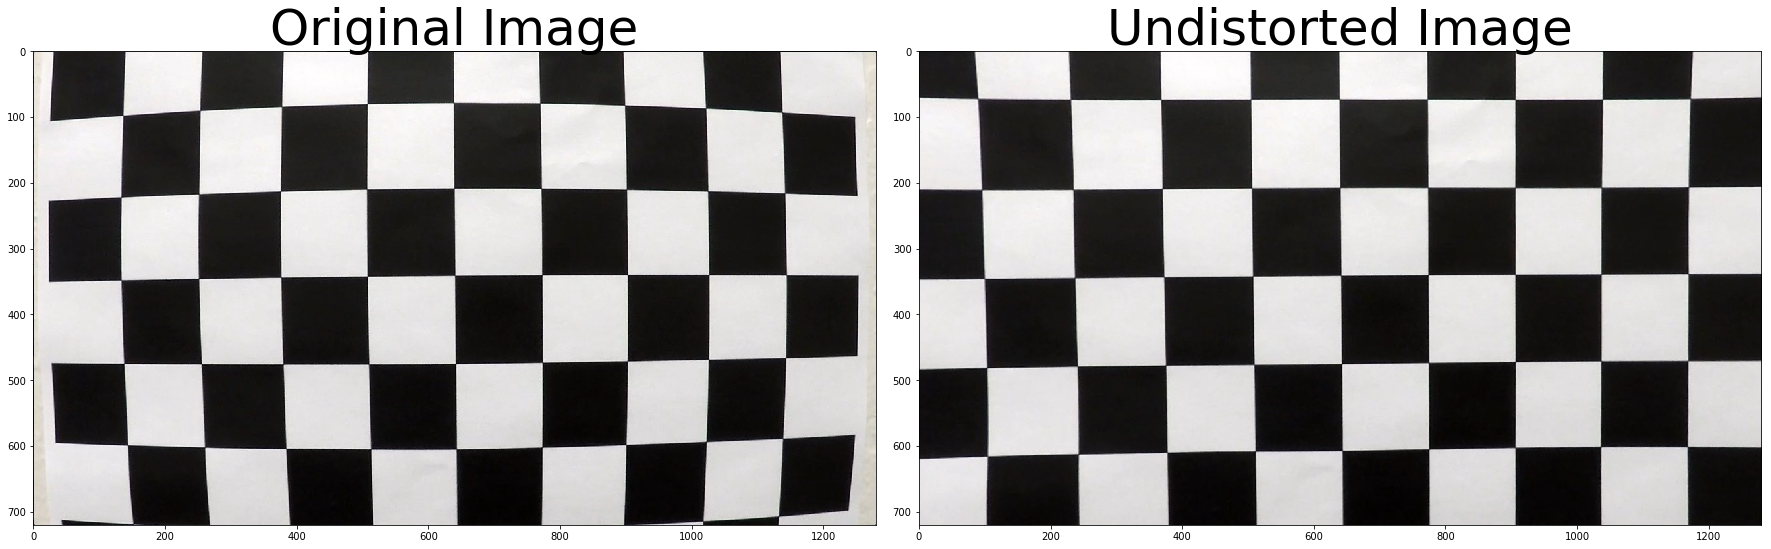

In [10]:
### Test with one raw image under folder ../camera_cal
ret,mtx,dist,rvecs,tvecs= cam_calibration(image_dir="../camera_cal/",nx=9,ny=6)

test_image= mpimg.imread("../camera_cal/calibration1.jpg")
#print("image before undistort")
#plt.imshow(test_image)
#undistorted_test_image=undistort(test_image,mtx,dist)
undistorted_test_image=undistort(test_image,mtx,dist,verbose= True)



In [11]:
def abs_sobel_thresh(img, orient='x', thresh=[0,255]):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    elif orient=="y":
        sobelx= cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude
# is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    ##Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread().
    ##Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
    # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    abs_sobelxy=np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(abs_sobelxy)
    binary_output[(abs_sobelxy >= mag_thresh[0]) & (abs_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as binary_output image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray_img= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the x and y gradients
    sobelx=np.absolute(sobelx)
    sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad=np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return binary_output

def compute_sobel_thresh(image,ksize,verbose=False):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(25, 255))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 2.0))
    
    if verbose:
        f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(gradx,cmap="gray")
        ax1.set_title('Gradx', fontsize=50)
        ax2.imshow(grady,cmap="gray")
        ax2.set_title('Grady', fontsize=50)
        ax3.imshow(mag_binary,cmap="gray")
        ax3.set_title('mag_binary', fontsize=50)
        ax4.imshow(dir_binary,cmap="gray")
        ax4.set_title('dir_binary', fontsize=50)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return gradx, grady, mag_binary,dir_binary


done


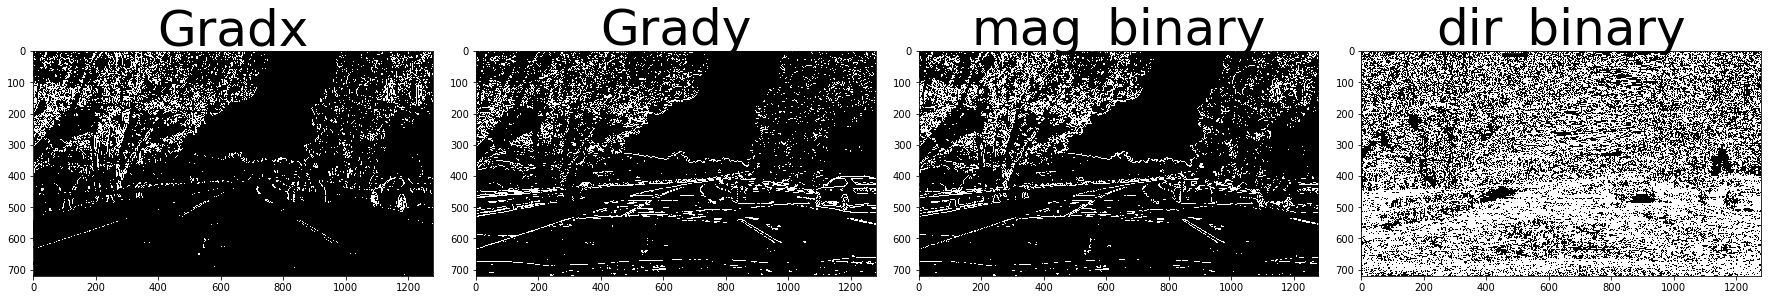

In [13]:
test_images = test_img= mpimg.imread("../test_images/test5.jpg")
gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(test_images,ksize=3,verbose= True)
cv2.imwrite('/Users/likangning/CarND-Advanced-Lane-lines/output_images/Gradx.jpg', gradx)
cv2.imwrite('/Users/likangning/CarND-Advanced-Lane-lines/output_images/Grady.jpg', grady)
cv2.imwrite('/Users/likangning/CarND-Advanced-Lane-lines/output_images/Mag_binary.jpg', mag_binary)
cv2.imwrite('/Users/likangning/CarND-Advanced-Lane-lines/output_images/Direction_binary.jpg', dir_binary)
print("done")

In [14]:
def extract_yellow(image,thresh,verbose=False):##[170,255]
    ### s_channel of HLS is the most important for yellow extraction.
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel=hls_image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    if verbose:
        plt.figure()
        plt.imshow(s_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return s_binary
    
    #yellow_lower = np.array([15,50,170])
    #yellow_upper = np.array([25,200,255])
    #return cv2.inRange(img_hls, yellow_lower, yellow_upper) // 255
def extract_yellow_update(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    yellow_lower = np.array([15,50,100])
    yellow_upper = np.array([25,200,255])
    
    extract_yellow_binary=cv2.inRange(hls_image, yellow_lower, yellow_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_yellow_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return extract_yellow_binary

def extract_white(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    white_lower = np.array([0,  200, 0])
    white_upper = np.array([255,255, 255])
    
    extract_white_binary=cv2.inRange(hls_image, white_lower, white_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_white_binary,cmap="gray")
        plt.title("extract_white_binary")
        
    return extract_white_binary


def combined_color_mask(image,verbose=False):
    yellow_binary=extract_yellow_update(image)
    white_binary=extract_white(image)
    color_mask=cv2.bitwise_or(yellow_binary, white_binary)
    
    if verbose:
        plt.imshow(color_mask,cmap="gray")
        plt.title("combined_color_mask")
        
    return color_mask


def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

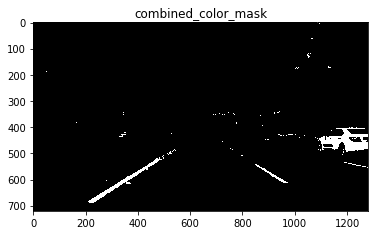

In [17]:
test_img= mpimg.imread("../test_images/test5.jpg")
#yellow_binary=extract_yellow(test_img,thresh=[170,255],verbose= True)
#yellow_binary=extract_yellow_update(test_img,verbose= True)
#white_binary=extract_white(test_img,verbose= True)
#color_mask = cv2.bitwise_or(yellow_binary, white_binary)
color_mask=combined_color_mask(test_img,verbose=True)
#plt.figure()
#plt.imshow(color_mask,cmap="gray")
#plt.title("combined_color_mask")




In [22]:
def final_mask_combination(img,verbose=False):###yellow_thresh[170,255]
    #yellow_binary=extract_yellow_update(img,verbose= False)
    #white_binary=extract_white(img,verbose= False)  
    color_mask = combined_color_mask(img)
    
    ##then compute the sobel gradient thresh.
    gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(img,ksize=3,verbose=False)
    #combined_sobel_mask=combined_sobel_gradient(gradx,mag_binary)
    Final_mask=cv2.bitwise_or(color_mask,gradx)
    #Final_mask=mask_to_rgb(Final_mask)
    #Final_mask= cv2.bitwise_or(color_mask,combined_sobel_mask)
    
    if verbose:
        plt.imshow(Final_mask,cmap="gray")
    return Final_mask

In [23]:
def perspect_trans(img,verbose=False):
    ####apply perspective transform to get the birdview of image
    img_size=(img.shape[1],img.shape[0])
    x1=205
    x2=1100
    y_rough=460
    offset= 100
    

    src=((x1,img.shape[0]),(x2,img.shape[0]),(700,y_rough),(585,y_rough))

    dst=((x1+offset,img.shape[0]),(x2-offset,img.shape[0]),(x2-offset,0),(x1+offset,0))
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)
    
    
    if verbose:
        #image_visual=img.copy()
        for i in range(4):
            img=cv2.line(img,src[i],src[(i+1)%4], color=[255,0,0],thickness=4)
            warped=cv2.line(warped,dst[i],dst[(i+1)%4], color=[255,0,0],thickness=4)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped,cmap="gray")
        ax2.set_title('BirdEye Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return M,Minv,warped

In [18]:
class Line:
    """
    Class to model a lane-line.
    """
    def __init__(self, buffer_len=10):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None

    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.
        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


def get_fits_by_sliding_windows(birdeye_binary, line_lt, line_rt, n_windows=9, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param n_windows: number of sliding windows used to search for the lines
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """
    height, width = birdeye_binary.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if verbose:
        f, ax = plt.subplots(1, 2)
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)

        plt.show()

    return line_lt, line_rt, out_img


def get_fits_by_previous_fits(birdeye_binary, line_lt, line_rt, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    This function starts from previously detected lane-lines to speed-up the search of lane-lines in the current frame.
    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """

    height, width = birdeye_binary.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if verbose:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit


def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines onto the original (undistorted) frame.
    :param img_undistorted: original undistorted color frame
    :param Minv: (inverse) perspective transform matrix used to re-project on original frame
    :param line_lt: left lane-line previously detected
    :param line_rt: right lane-line previously detected
    :param keep_state: if True, line state is maintained
    :return: color blend
    """
    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road


TypeError: 'NoneType' object is not subscriptable

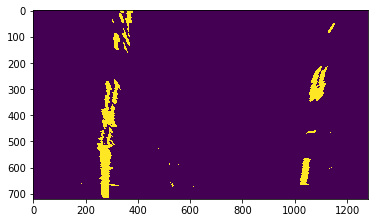

In [24]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)
test_img= mpimg.imread("../test_images/test5.jpg")
img_undistorted = undistort(test_img, mtx, dist, verbose=False)
img_binary = final_mask_combination(img_undistorted, verbose=False)
img_birdeye, M, Minv = perspect_trans(img_binary, verbose=False)
line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, verbose=True)

In [ ]:
(nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin))


(nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin))


In [ ]:
(nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin))
&(nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin))